In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import math 
import xgboost as xgb
np.random.seed(2019)
from scipy.stats import skew
from scipy import stats

import statsmodels
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
print("done")

done


In [3]:
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data

train, test, data = read_and_concat_dataset('../data/train.csv', '../data/test.csv')

In [4]:
def comparing_variables(data,variable1, variable2):
    print(data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False))
    g = sns.FacetGrid(data, col=variable2).map(sns.distplot, variable1)
    
def counting_values(data, variable1, variable2):
    data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False)    

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


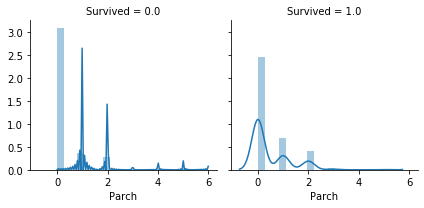

In [5]:
comparing_variables(data, 'Parch','Survived')

   Women  Survived
1      1  0.742038
0      0  0.188908


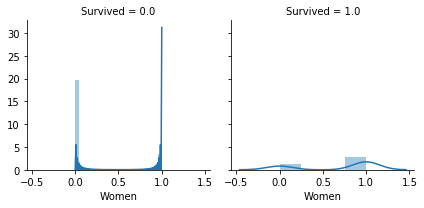

In [6]:
data['Women'] = np.where(data.Sex=='female',1,0)
comparing_variables(data, 'Women','Survived')

In [7]:
def filling_missing_values(data,variable, new_value):
    data[variable] = data[variable].fillna(new_value)

In [9]:
filling_missing_values(data,'Fare', 0)
filling_missing_values(data,'Embarked', 'S')

In [10]:
filling_missing_values(data,'Cabin', 'Unknown')
data['Cabin'] = data['Cabin'].str[0]

In [11]:
data['Cabin'] = np.where((data.Pclass==1) & (data.Cabin=='U'),'C',
                                            np.where((data.Pclass==2) & (data.Cabin=='U'),'D',
                                                                        np.where((data.Pclass==3) & (data.Cabin=='U'),'G',
                                                                                                    np.where(data.Cabin=='T','C',data.Cabin))))

In [12]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data['Title'], data['Sex'])
data = data.drop('Name',axis=1)

In [13]:
data['Title'] = np.where((data.Title=='Capt') | (data.Title=='Countess') | (data.Title=='Don') | (data.Title=='Dona')
                        | (data.Title=='Jonkheer') | (data.Title=='Lady') | (data.Title=='Sir') | (data.Title=='Major') | (data.Title=='Rev') | (data.Title=='Col'),'Other',data.Title)

data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')

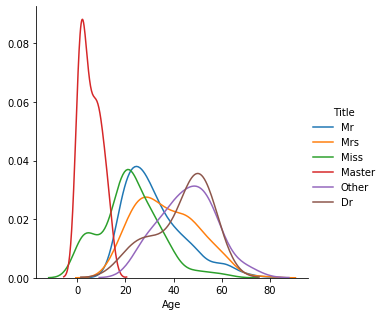

In [14]:
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = data, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

In [15]:
data['Age'] = np.where((data.Age.isnull()) & (data.Title=='Master'),5,
                        np.where((data.Age.isnull()) & (data.Title=='Miss'),22,
                                 np.where((data.Age.isnull()) & (data.Title=='Mr'),32,
                                          np.where((data.Age.isnull()) & (data.Title=='Mrs'),37,
                                                  np.where((data.Age.isnull()) & (data.Title=='Other'),45,
                                                           np.where((data.Age.isnull()) & (data.Title=='Dr'),44,data.Age))))))   

In [16]:
data['FamilySize'] = data.SibSp + data.Parch + 1
data['Mother'] = np.where((data.Title=='Mrs') & (data.Parch >0),1,0)
data['Free'] = np.where(data['Fare']==0, 1,0)
data = data.drop(['SibSp','Parch','Sex'],axis=1)

In [17]:
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket

data.TypeOfTicket.value_counts()
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'other',data.TypeOfTicket)
data = data.drop('Ticket',axis=1)

In [18]:
bins = [0,12,24,45,60,data.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
data["Age"] = pd.cut(data["Age"], bins, labels = labels)

In [19]:
data = pd.get_dummies(data)

In [20]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[data.Survived.isnull()==False].drop('Survived',axis=1),data.Survived[data.Survived.isnull()==False],test_size=0.30, random_state=2019)

In [21]:
Results = pd.DataFrame({'Model': [],'Accuracy Score': []})

In [22]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['KNeighborsClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [25]:
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [27]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [28]:
Results

,Model,Accuracy Score
0,DecisionTreeClassifier,0.802239
0,RandomForestClassifier,0.832090
0,KNeighborsClassifier,0.623134
0,SVC,0.585821
0,LogisticRegression,0.832090
0,XGBClassifier,0.850746


In [29]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
test = data[data.train==0]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submissionXGB2.csv",index=False)
print("done1")

done1


In [42]:
trainX['Survived'] = trainY
trainX.to_csv('../data/org/train2.csv', index = False)
test = test.drop(['index', 'Survived', 'train'], axis = 1, errors = 'ignore')
test.to_csv('../data/org/test2.csv', index = False)

In [30]:
# 다음은 그냥 내가 비교한것임
data1 = pd.read_csv('submissionXGB.csv')
data2 = pd.read_csv('submissionXGB2.csv')

In [32]:
data = pd.merge(data1, data2, how = 'inner', left_on = 'PassengerId', right_on = 'PassengerId')
print(data.shape)
data.head()

(418, 3)


,PassengerId,Survived_x,Survived_y
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,0,1


In [33]:
diff = data[data['Survived_x'] != data['Survived_y']]

In [34]:
print(diff.shape)
diff.head()

(2, 3)


,PassengerId,Survived_x,Survived_y
4,896,0,1
34,926,0,1
